# 1. Importing Packages

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from numpy.random import randint
import numpy as np
print("imports successful")

imports successful


# 2. Background
<!---defining ket notation for redering--->
 $\newcommand{\ket}[1]{\left|#1\right>}$
 
## 2.1 Intuition

Here our aim is to send the key from Alice(A) to Bob(B) secretly while making sure tha it is not intercepted by somebody else(i.e. Eve(E)) on the way from A to B.


In other words if the key is intercepted/deciphered by Eve it should be notified so asto prevent the use of leaked key.

This is precisely what Quantum Key distribution(formaly known as BB84 algorithm) does.

## 2.2 Actual process

     1. We choose a random key in binary 0101
     2. We choose a random basis to encode this 0s and 1s i.e. $\ket{+}$ / $\ket{-}$ or $\ket{0}$ / $\ket{1}$ basis
     3. Bob then measures these qubit in his own random basis
     4. Thus he obtains his sequence of 0s and 1s 
     5. Both Bob and Alice relase their measuring bases and only the common ones are kept 
     6. Finally both Bob and ALice share a random list of 0s and 1s that are common
     
This is the case if no one was spying on them. If they were being spied upon by Eve then she would measure the qubits before bob could have the chance. This would destroy the superposition and collapse it to 0 or 1 state. Now when bob measures the qubit, which Alice had encoded to be 1 and in X/Z basis, in the same state as alice's i.e. even if their states macth he would now have a 50/50 chance of measuring it as 0 or 1. Post the transaction is complete B sends few of the randomly sampled qubits value to alice to do a check if they are the same. If they are not the same it can be concluded that Eve has gotten hold of these set of keys and it would then be discarded.  

For more details : <a href="https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html#3.-Qiskit-Example:-Without-Interception" > link </a>

# 3. Implementation without interference

## 3.1 Alice's side

In [35]:
np.random.seed(seed=0)
n=100

# step 1 generate bits
alice_bits=randint(2,size=n)

# Step 2 select basis
alice_bases=randint(2,size=n)


In [36]:
def encode_msg(bits,bases):
    msg=[]
    for i in range(n):
        qc=QuantumCircuit(1,1)
        if bases[i]==0:
            if bits[i]==0:
                pass
            else:
                qc.x(0)
        else:
            if bits[i]==0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        msg.append(qc)
    return msg

In [37]:
msg=encode_msg(alice_bits,alice_bases)

## 3.2 Bob's side

In [38]:
bobs_bases=randint(2,size=n)

In [39]:
def decode_msg(msg,bases):
    backend=Aer.get_backend('qasm_simulator')
    meas=[]
    for i in range(n):
        if bases[i]==0:
            msg[i].measure(0,0)
        elif bases[i]==1:
            msg[i].h(0)
            msg[i].measure(0,0)
        result=execute(msg[i],backend=backend,shots=1,memory=True).result()
        meas.append(int(result.get_memory()[0]))
    return meas

In [40]:
bob_res=decode_msg(msg,bobs_bases)

## 3.3 Correcting the alice's key based on bob's bases 

In [41]:
def remove_garbage(a_bases,b_bases,bits):
    good_bits=[]
    for i in range(n):
        if a_bases[i]==b_bases[i]:
            good_bits.append(bits[i])
    return good_bits

In [42]:
a_key= remove_garbage(alice_bases,bobs_bases,alice_bits)
print(len(a_key))

48


In [43]:
b_key= remove_garbage(alice_bases,bobs_bases,bob_res)
print(len(b_key))

48


## 3.4 Random sampling to chceck the interference

In [44]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        i = np.mod(i, len(bits))
        sample.append(bits.pop(i))
    return sample

In [45]:
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(b_key, bit_selection)
print("  Bob_sample = " + str(bob_sample))
alice_sample = sample_bits(a_key, bit_selection)
print("Alice_sample = "+ str(alice_sample))

  Bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [46]:
bob_sample==alice_sample

True

In [47]:
print("Final key length",len(a_key)) 

Final key length 33


# 4. Implementation with Eve 

In [56]:
np.random.seed(seed=0)
n=100

# step 1 generate bits
alice_bits=randint(2,size=n)

# Step 2 select basis
alice_bases=randint(2,size=n)

# step 3 send message
msg=encode_msg(alice_bits,alice_bases)


In [57]:
# Intercepted by Eve
eve_bases = randint(2, size=n)
intercepted_message = decode_msg(msg, eve_bases)
print(intercepted_message)

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]


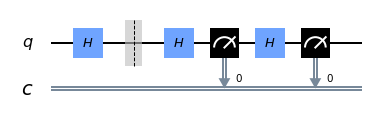

In [58]:
#step 4 measured by Bob
bob_bases = randint(2, size=n)
bob_results = decode_msg(msg, bob_bases)

# An example of first case
msg[0].draw('mpl')

In [59]:
# step 5 Removing garbage
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

In [60]:
## Step 6 checking with the sample
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]
alice_sample = [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]


In [61]:
bob_sample==alice_sample

False

This shows how Eve can be caught 